In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import ast

import pandas as pd
import numpy as np
from tqdm import tqdm
import ast

cc_codes = ["uk", "de", "pl", "es", "ru", "en"]
filename_pattern_train = "data/multilingual_train/train_{}.csv".format("_".join(cc_codes))

data = pd.read_csv(filename_pattern_train)
data = data[data["is_text_train"] == 1]

/home/trokhymovych/.conda/envs/2022-08-18T15.21.49_trokhymovych/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3186: DtypeWarning: Columns (24) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
MIN_REV = 5

titles_stats = data.groupby("page_title").agg({"revision_is_identity_reverted": ["mean", "count"], "wiki_db":["first"]}).reset_index()
titles_stats.columns = ["page_title", "label", "rev_count", "wikidb"]
titles_stats = titles_stats[titles_stats.rev_count >= MIN_REV]
titles_stats.page_title = titles_stats.page_title.apply(lambda x: x.replace("_", " "))
titles_stats.to_csv("data/multilingual_train/titles_semantic.csv", index=False)

## Modeling attemp: 

In [3]:
from datasets import load_dataset, load_metric, Dataset, ClassLabel
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

In [4]:
training_dataset = Dataset.from_csv("data/multilingual_train/titles_semantic.csv")
training_dataset = training_dataset.train_test_split(test_size=0.1, shuffle=True, seed=42)

Using custom data configuration default-072050b451829ce7


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /home/trokhymovych/.cache/huggingface/datasets/csv/default-072050b451829ce7/0.0.0. Subsequent calls will reuse this data.


In [11]:
training_dataset['test'][4]

{'page_title': 'Iskander', 'label': 0.0, 'rev_count': 5, 'wikidb': 'eswiki'}

In [6]:
training_dataset['train'][0]

{'page_title': 'Sheesh', 'label': 0.8, 'rev_count': 5, 'wikidb': 'enwiki'}

In [7]:
# tokenization:
model_checkpoint = 'bert-base-multilingual-cased'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

sentence1_key = "page_title"
sentence2_key = None

def preprocess_function(examples):
    return tokenizer(examples[sentence1_key], truncation=True,  max_length=512)
    
encoded_dataset = training_dataset.map(preprocess_function, batched=True)

  0%|          | 0/31 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

In [12]:
num_labels = 1
metric_name = "rmse"
model_name = model_checkpoint.split("/")[-1]
batch_size = 8
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

args = TrainingArguments(
    f"title_{model_name}-finetuned-multi_balanced",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    push_to_hub=False,
)

from datasets import load_metric
from sklearn.metrics import mean_squared_error
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    rmse = mean_squared_error(labels, predictions, squared=False)
    return {"rmse": rmse}

trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

In [ ]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: rev_count, page_title, wikidb. If rev_count, page_title, wikidb are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/home/trokhymovych/.conda/envs/2022-08-18T15.21.49_trokhymovych/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 30825
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 19270


Epoch,Training Loss,Validation Loss


In [19]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: rev_count, page_title, wikidb. If rev_count, page_title, wikidb are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 3425
  Batch size = 8


{'eval_loss': 0.1402098685503006,
 'eval_rmse': 0.3744460940361023,
 'eval_runtime': 5.6925,
 'eval_samples_per_second': 601.67,
 'eval_steps_per_second': 75.362,
 'epoch': 5.0}

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: rev_count, page_title, wikidb. If rev_count, page_title, wikidb are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 3425
  Batch size = 8


,count,mean,std,min,25%,50%,75%,max
revision_is_identity_reverted,,,,,,,,
0.000000,536.0,0.414486,0.303630,-0.009320,0.138834,0.367972,0.670771,1.008016
0.018182,1.0,0.493463,NaN,0.493463,0.493463,0.493463,0.493463,0.493463
0.019417,1.0,0.390284,NaN,0.390284,0.390284,0.390284,0.390284,0.390284
0.019608,1.0,0.307571,NaN,0.307571,0.307571,0.307571,0.307571,0.307571
0.033333,1.0,0.701531,NaN,0.701531,0.701531,0.701531,0.701531,0.701531
...,...,...,...,...,...,...,...,...
0.965517,1.0,0.986824,NaN,0.986824,0.986824,0.986824,0.986824,0.986824
0.968750,1.0,0.606951,NaN,0.606951,0.606951,0.606951,0.606951,0.606951
0.970588,1.0,0.595421,NaN,0.595421,0.595421,0.595421,0.595421,0.595421


<AxesSubplot:title={'center':'prediction_score'}, xlabel='revision_is_identity_reverted'>

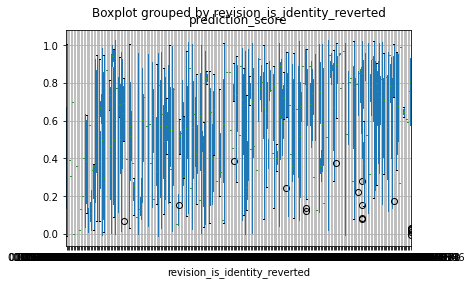

In [20]:
predictions = trainer.predict(encoded_dataset["test"])
test = pd.DataFrame({
                       "prediction_score": predictions.predictions[:, 0],
                       "revision_is_identity_reverted": predictions.label_ids
                      })
display(test.groupby("revision_is_identity_reverted")["prediction_score"].describe())
test.boxplot(column="prediction_score", by="revision_is_identity_reverted")

/home/trokhymovych/.conda/envs/2022-08-18T15.21.49_trokhymovych/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


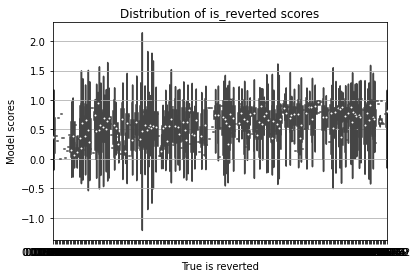

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots()
# plot violin. 'Scenario' is according to x axis, 
# 'LMP' is y axis, data is your dataframe. ax - is axes instance
sns.violinplot('revision_is_identity_reverted', "prediction_score", data=test, ax = axes)
axes.set_title('Distribution of is_reverted scores')

axes.yaxis.grid(True)
axes.set_xlabel('True is reverted')
axes.set_ylabel('Model scores')

plt.show()

<AxesSubplot:xlabel='prediction_score', ylabel='revision_is_identity_reverted'>

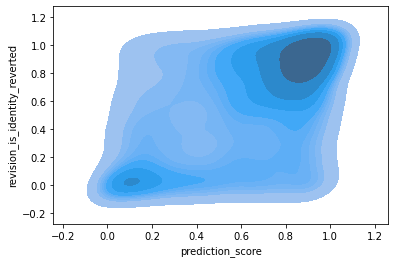

In [22]:
import seaborn as sns
# sns.distplot(test.prediction_score, test.revision_is_identity_reverted)

sns.kdeplot(
    data=test, x="prediction_score", y="revision_is_identity_reverted", fill=True,
)

<AxesSubplot:xlabel='prediction_score', ylabel='revision_is_identity_reverted'>

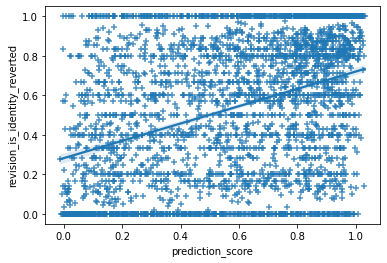

In [23]:
sns.regplot(x="prediction_score", y="revision_is_identity_reverted", data=test, marker="+", )